In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from open3d.web_visualizer import draw

%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [15]:
# TODO : write a lidar file path, an img flie and calib file path
lidar_path = '/home/server-003/workspace/data/calibration/pcd/20220812_114259.619102.pcd'
img_path = '/home/server-003/workspace/data/calibration/png/20220812_114259.619102.png'
camera_matrix_path = '/home/server-003/workspace/data/calibration/camera_matrix.txt'
extrinsic_matrix_path = '/home/server-003/workspace/data/calibration/extrinsic_matrix.txt'


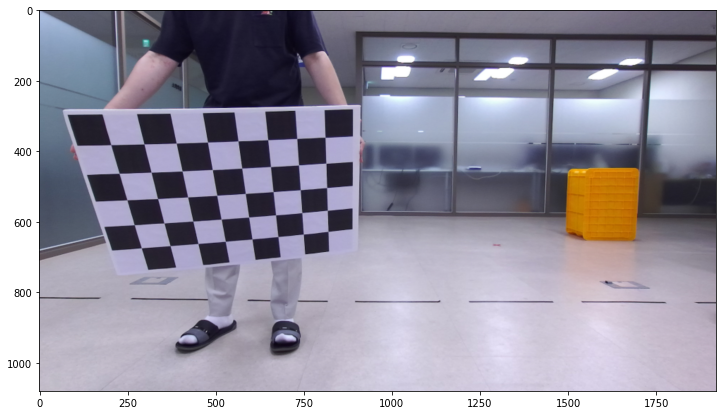

In [16]:
# load img file
image = cv2.imread(img_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]
plt.subplots(1, 1, figsize=(17, 7))
plt.imshow(image)


#pcd
pcd = o3d.io.read_point_cloud(lidar_path) 
pcd_array = np.asarray(pcd.points)
points_shape = pcd_array.shape
ones = np.ones((points_shape[0], 1))
pcd_homo = np.concatenate([pcd_array, ones], axis=1)


In [17]:
draw(pcd)

[Open3D INFO] Window window_1 created.


WebVisualizer(window_uid='window_1')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate


In [18]:
def calib_velo2cam(filepath):
    RT = np.fromfile(extrinsic_matrix_path, sep=' ', dtype=np.float32).reshape(4, 4)
    R = RT[:3, :3]
    T = RT[:3,3].reshape(3,1)
    
    print(f'R: \n{R}')
    print("******************************************")
    print(f'T: \n{T}')
    print("******************************************")
    return RT,R,T

def load_camera_matrix(filepath):
    with open(filepath, "r") as f:
        file = f.readlines()
        for line in file:
            (key, val) = line.split(':', 1)
            if key == 'camera matrix':
                intrinsic_matrix = np.fromstring(val, sep=' ')
                intrinsic_matrix = intrinsic_matrix.reshape(3, 3)
            if key == 'distortion':
                distortion = np.fromstring(val, sep=' ')
                distortion = distortion.reshape(1, -1)
   
    print(f'intrinsic_matrix : \n {intrinsic_matrix}')
    print("******************************************")
    print(f'distortion: \n{distortion}')
    print("******************************************")
    return intrinsic_matrix,distortion

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers


In [19]:
def velo3d_2_camera2d_points(points, vc_path, cc_path):
    RT,R,T = calib_velo2cam(vc_path)
    intrinsic_matrix,distortion = load_camera_matrix(camera_matrix_path)
    rodri_R = cv2.Rodrigues(R)[0]
    proj, _ = cv2.projectPoints(points, rodri_R, T, intrinsic_matrix, distortion);
    proj = proj.squeeze()
#     proj.reshape(-1,2)
#     print(proj.shape)
    eff_inds = (
        (proj[:, 0] < width)
        & (proj[:, 0] >0)
        & (proj[:, 1] < height)
        & (proj[:, 1] > 0)
    )
    eff_pcd_img = proj[eff_inds, :]
    eff_inds_where = np.where(eff_inds)[0]
    cam_points = np.dot(RT, pcd_homo.T).T
    
    return cam_points,eff_pcd_img, eff_inds_where

In [20]:
# print(cam_points.shape)
# print(eff_pcd_img.shape)
# print(eff_inds_where.shape)

[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.806812635650846
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.806812635650846
[Open3D INFO] Sending init frames to window_1.


In [21]:
cam_points,eff_pcd_img, eff_inds_where = velo3d_2_camera2d_points(pcd_array, extrinsic_matrix_path, camera_matrix_path)
cmap = plt.cm.get_cmap("hsv", 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
img_lidar = np.copy(image)

for i in range(eff_pcd_img.shape[0]):
    pcd_cam_idx = eff_inds_where[i]
    pcd_cam_value = cam_points[pcd_cam_idx, :]
#     print(pcd_cam_value.shape)
#     print(pcd_cam_value)
    depth = pcd_cam_value[2]
#     depth = np.sqrt(pcd_cam_value[0]**2 + pcd_cam_value[1]**2+ pcd_cam_value[2]**2)
    if depth < 0 or depth > 120:
        continue
    color = cmap[int(abs(640.0 / depth)) % 256, :]
    cv2.circle(
        img_lidar,
        (int(np.round(eff_pcd_img[i, 0])), int(np.round(eff_pcd_img[i, 1]))),
        2,
        color=tuple(color),
        thickness=-1,
    )

R: 
[[-0.999518  -0.0261984 -0.0166483]
 [ 0.014704   0.0727349 -0.997243 ]
 [ 0.0273371 -0.997007  -0.0723146]]
******************************************
T: 
[[ 0.100983 ]
 [ 0.0453649]
 [-0.0765071]]
******************************************
intrinsic_matrix : 
 [[1.04105195e+03 0.00000000e+00 9.34083017e+02]
 [0.00000000e+00 1.04005103e+03 5.51328482e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
******************************************
distortion: 
[[-0.09354321  0.13098088 -0.00655748 -0.00089274  0.        ]]
******************************************


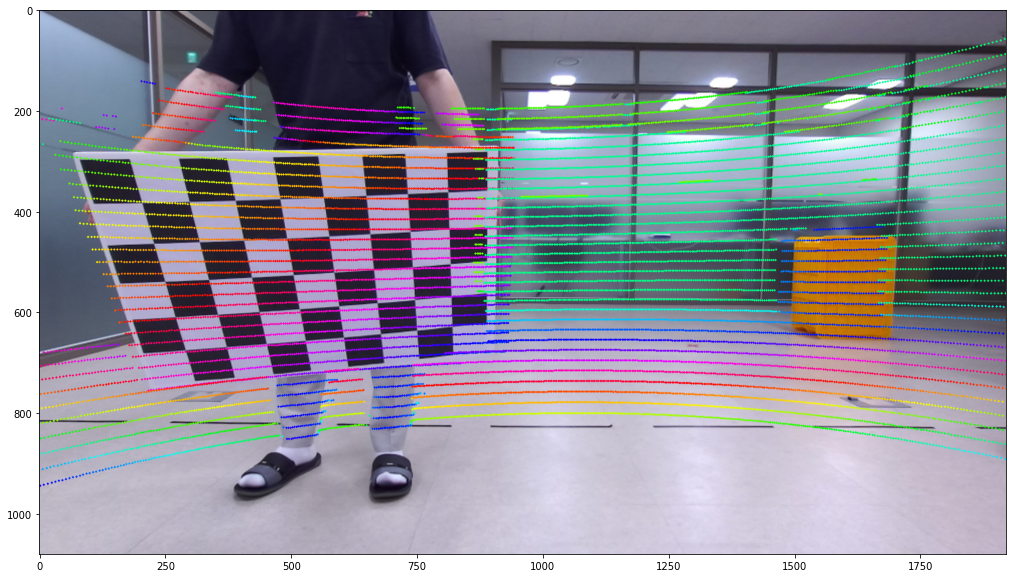

[136:538][398164] (stun_port.cc:96): Binding request timed out from 192.168.219.x:49464 (wlp147s0)
[58371:705][398164] (stun_port.cc:308): Port[98073c30:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 96 bytes failed with error 101
[58371:955][398164] (stun_port.cc:308): Port[98073c30:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 96 bytes failed with error 101
[58372:003][398164] (stun_port.cc:308): Port[98073c30:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 96 bytes failed with error 101
[58372:051][398164] (stun_port.cc:308): Port[98073c30:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 96 bytes failed with error 101
[58372:099][398164] (stun_port.cc:308): Port[98073c30:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 96 bytes failed with error 101
[58372:521][398164] (stun_port.cc:308): Port[980076d0:0:1:0:local:Net[wlp147s0:192.168.219.x/24:Unknown:id=3]]: UDP send of 70

In [22]:
fig_lidar = plt.figure(figsize=(18, 10))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()